# Run network model

In [1]:
%load_ext autoreload
%autoreload 2

#from keras.layers import merge
from src.models.data import *
from src.models.model import *
from src.data.utils import get_tile_prefix
from src.models.metrics_img import auc_roc
#import rasterio.plot as rioplot
import matplotlib
import matplotlib.pyplot as plt
#import matplotlib.image as mpimg

from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping

from pathlib import Path
import os, shutil
import sys
%matplotlib inline

Using TensorFlow backend.


## User settings

In [3]:
# paths to append
sys.path.append("/home/ubuntu/roaddetection/")
sys.path.append("/media/hh/hd_internal/hh/DSR_Berlin_2018/roaddetection/")

# ------------- image characteristics and augmentation -----------------------------
# size of tiles
target_size = (512,512)
# input arguments to Keras' ImageDataGenerator
data_gen_args = dict(
                    data_format="channels_last",
                    horizontal_flip=True, 
                    vertical_flip=True
 )
# if True, image tiles will be split up into training/validation/test sets
# only required after a fresh 'make data'
do_data_split = False
# directory into which to place *training* images from ImageDataGenerator for inspection;
# default should be None because this slows things down
imgdatagen_dir = None
#imgdatagen_dir = '../../data/imgdatagenerator'

#--------------- network weights ----------------------------------------------------
# path to & filename of pre-trained model to use - set to None if you want to start from scratch
# pretrained_model_fn = "../../models/unet_membrane_analytic_27_08_14_55.hdf5"
pretrained_model_fn = '../../models/unet_only_borneo_03_09_10_51.hdf5'

# path to & filename of model to save
trained_model_fn = '../../models/unet_only_borneo_03_09_10_51.hdf5'

#--------------- training details / hyperparameters -----------------------------------
# batch size
batch_size = 3
# steps per epoch, should correspond to [number of training images] / batch size
steps_per_epoch = 100
# number of epochs
epochs = 5
# number of steps on validation set
validation_steps = 20
# self-explanatory variables:
optimizer = Adam(lr=1e-4)
loss = 'binary_crossentropy'
loss_weights = None
metrics = ['accuracy', auc_roc]

### Define and make (if necessary) train/validation/test directories

In [4]:
original_dataset_dir = "../../data/train"
raw_images_path = "../../data/raw/images"
dirs = []

base_dir = "../../data"

train_dir = os.path.join(base_dir, "train")
dirs.append(train_dir)
validation_dir = os.path.join(base_dir, "validate")
dirs.append(validation_dir)
test_dir = os.path.join(base_dir, "test")
dirs.append(test_dir)

In [5]:
for directory in dirs:
    if not os.path.exists(directory):
        os.mkdir(directory)

In [6]:
# Delete map, sat, sat_rgb tiles with (almost) zero road labels 

import skimage.io as io

def should_delete(fname):
    img = io.imread(fname.as_posix())
    almost_empty = not len(img[img!=0.0]) > 5000
#     almost_empty = not np.any(img)
    return almost_empty
    
tiles_with_no_roads = [ fname.name for fname in 
                          Path( os.path.join(train_dir, 'map')).iterdir() 
                       if should_delete(fname) ]

print(len(tiles_with_no_roads))
print("Deleting {} tiles with no roads".format(len(tiles_with_no_roads)))
for fname in tiles_with_no_roads:
    for file_type in ["sat", "map", "sat_rgb"]:
        src = os.path.join(train_dir, file_type, fname)
        if(os.path.exists(src)):
            os.remove(src)

0
Deleting 0 tiles with no roads


### Split data up into train/validation/test images

In [7]:
if do_data_split:
    def should_make_tiles_from(r_analytic_name):
        is_analytic_tif = r_analytic_name.endswith(
            ('AnalyticMS.tif', 'AnalyticMS_SR.tif', 'AnalyticMS.tiff', 'AnalyticMS_SR.tiff')
        )
        return is_analytic_tif 

    file_prefixes = [ get_tile_prefix(r_analytic.name) 
                      for r_analytic in Path(raw_images_path).iterdir()  
                        if  should_make_tiles_from(r_analytic.name)
                    ]
#     print(file_prefixes)

    # move files to validation dir
    validation_fnames = ["{0:s}_{1:04d}.tif".format(prefix, i) for i in range(10,45) for prefix in file_prefixes]
    for fname in validation_fnames:
        for file_type in ["sat", "map", "sat_rgb"]:
            src = os.path.join(train_dir, file_type, fname)
            dest = os.path.join(validation_dir, file_type, fname)
            if(os.path.exists(src)):
                shutil.move(src, dest)
    # move files to test dir
    test_fnames = ["{0:s}_{1:04d}.tif".format(prefix, i) for i in range(40,60) for prefix in file_prefixes]
    for fname in test_fnames:
        for file_type in ["sat", "map", "sat_rgb"]:
            src = os.path.join(train_dir, file_type, fname)
            dest = os.path.join(test_dir, file_type, fname)
            if(os.path.exists(src)):
                shutil.move(src, dest)
    # print overview
    for directory in dirs:
        for file_type in ["sat", "map", "sat_rgb"]:
            target = os.path.join(directory, file_type)
            print(target, ":", len(os.listdir(target)))

    print("Done.")

### Set up ImageDataGenerators for training and validation sets

In [8]:
train_gen = trainGenerator(batch_size,'../../data/train','sat','map',
                        data_gen_args, save_to_dir = imgdatagen_dir, image_color_mode="rgba", target_size=target_size)

validation_gen = trainGenerator(batch_size,'../../data/validate','sat','map',
                        data_gen_args, save_to_dir = None, image_color_mode="rgba", target_size=target_size)

### Define model, compile, show summary, possibly load weights, define callbacks (including checkpoints)

In [9]:
model = unet()
model.compile(optimizer=optimizer,
              loss=loss,
              loss_weights=loss_weights,
              metrics=metrics)
model.summary()
if (pretrained_model_fn):
    model.load_weights(pretrained_model_fn)
model_checkpoint = ModelCheckpoint(trained_model_fn, monitor='loss',verbose=1, save_best_only=True)

#Stop training if loss doesn't improve for 2 consecutive epochs
early_stop = EarlyStopping(monitor='loss', min_delta=0, patience=2, verbose=1, mode='auto', baseline=None)

/home/ubuntu/roaddetection/src/models/model.py:58: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`
  model = Model(input=inputs, output=conv10)


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 512, 512, 4)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 512, 512, 64) 2368        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 512, 512, 64) 36928       conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 256, 256, 64) 0           conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (

### Run training

In [10]:
history = model.fit_generator(train_gen,
                              steps_per_epoch=steps_per_epoch,
                              epochs=epochs,
                              callbacks=[model_checkpoint, early_stop],
                              validation_data=validation_gen,
                              validation_steps=validation_steps
                             )

Epoch 1/5
Found 15 images belonging to 1 classes.
Found 150 images belonging to 1 classes.
Found 150 images belonging to 1 classes.
Found 15 images belonging to 1 classes.
100/100 [==============================] - 268s 3s/step - loss: 0.1203 - acc: 0.9692 - auc_roc: 0.7093 - val_loss: 0.1087 - val_acc: 0.9766 - val_auc_roc: 0.7755

Epoch 00001: loss improved from inf to 0.12028, saving model to ../../models/unet_only_borneo_03_09_10_51.hdf5
Epoch 2/5
100/100 [==============================] - 248s 2s/step - loss: 0.1099 - acc: 0.9692 - auc_roc: 0.7890 - val_loss: 0.0926 - val_acc: 0.9766 - val_auc_roc: 0.8033

Epoch 00002: loss improved from 0.12028 to 0.10995, saving model to ../../models/unet_only_borneo_03_09_10_51.hdf5
Epoch 3/5
100/100 [==============================] - 248s 2s/step - loss: 0.1056 - acc: 0.9692 - auc_roc: 0.8113 - val_loss: 0.0946 - val_acc: 0.9766 - val_auc_roc: 0.8181

Epoch 00003: loss improved from 0.10995 to 0.10561, saving model to ../../models/unet_only_bo

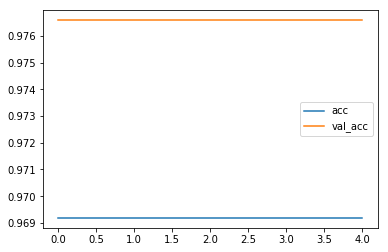

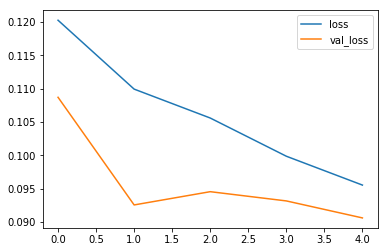

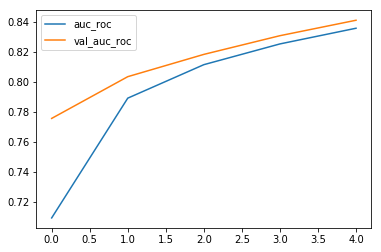

In [11]:
import matplotlib.pyplot as plt

def plot_history(history):
    plt.plot(history["acc"], label="acc")
    plt.plot(history["val_acc"], label="val_acc")
    plt.legend()
    plt.show()
    plt.close()
    
    plt.plot(history["loss"], label="loss")
    plt.plot(history["val_loss"], label="val_loss")
    plt.legend()
    plt.show()
    plt.close()

    plt.plot(history["auc_roc"], label="auc_roc")
    plt.plot(history["val_auc_roc"], label="val_auc_roc")
    plt.legend()
    plt.show()
    plt.close()

plot_history(history.history)

In [12]:
testGene = testGenerator("../../data/test/sat",target_size=(512,512),as_gray=False)
n = 0
for img, name in testGene:
    results = model.predict(img, batch_size=1)
    saveResult("../../data/test/predict", results, name)
    n += 1
    if(n>300):
        break

/home/ubuntu/.local/lib/python3.5/site-packages/skimage/io/_io.py:140: UserWarning: ../../data/test/predict/20171013_232848_0c46_3B_0051.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ubuntu/.local/lib/python3.5/site-packages/skimage/io/_io.py:140: UserWarning: ../../data/test/predict/20171013_232848_0c46_3B_0050.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ubuntu/.local/lib/python3.5/site-packages/skimage/io/_io.py:140: UserWarning: ../../data/test/predict/20171013_232848_0c46_3B_0058.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
